#### Understand the lifestyle of remote workers (v non-remote workers)
- When, where and for how long do they work?
- Typical occupations/industries?
- Demographics? (State? Age? Gender? Salary? Edu? Married? Kids?)
- How do they spend their time?

As a consultant, I also want to help my husband who is about to become a remote worker how to manage working hours better (i.e. not work too long) - probably run a correlation analysis, or linear reg?

Deliverable: animated visualization over time?

In [67]:
import os
import re
import pandas as pd
import numpy as np
%matplotlib inline

#### 0.1 Figure out people who have a full-time job

In [6]:
summ = pd.read_csv(r"../data/converted/summary_4d.csv")
ft = summ[summ['TELFS']==1] # 1 for full-time
del summ
ft.shape

(108151, 132)

In [8]:
ft[:3]

TUCASEID  GEMETSTA  GTMETSTA  PEEDUCA  PEHSPNON  PTDTRACE  TEAGE  \
1  20030100013344         2        -1       40         2         1     41   
4  20030100014165         2        -1       45         2         1     51   
6  20030100014209         1        -1       39         2         1     44   

   TELFS  TEMJOT  TESCHENR  ...    t1811  t1812  t1813  t1814  t1815  t1816  \
1      1       2         2  ...        0     20      0      0      0      0   
4      1       2        -1  ...        0      0     10      0      0      0   
6      1       2         2  ...       12      0      0      0      0      0   

   t1818  t1899  t5001  t5099  
1      0      0      0      0  
4      0      0      0      0  
6      0      0      0      0  

[3 rows x 132 columns]

In [41]:
dt = pd.read_csv(r"../data/converted/resp.csv")

In [24]:
ft_dt = pd.merge(ft[['TUCASEID','TELFS']],dt,how='left')
# del dt
ft_dt.shape

(108151, 24)

In [39]:
act = pd.read_csv(r"../data/converted/act.csv")

In [44]:
ft_act = pd.merge(ft_dt[['TUCASEID','TUDIARYDATE','TUDIARYDAY','TRHOLIDAY']],act,how='left')
del act
ft_act.shape

(2133739, 9)

#### 0.2 Separate remote & non-remote workers

In [45]:
ft_act['TRTIER2P'] = ft_act['TRTIER2P'].astype(str).str.zfill(4)
ft_act['TUDIARYDATE'] = pd.to_datetime(ft_act['TUDIARYDATE'],format='%Y%m%d')
ft_act[:3]
# week: Sun -- Sat(7)

TUCASEID TUDIARYDATE  TUDIARYDAY  TRHOLIDAY  TUACTIVITY_N  \
0  20030100013344  2003-01-04           7          0             1   
1  20030100013344  2003-01-04           7          0             2   
2  20030100013344  2003-01-04           7          0             3   

   TUACTDUR24 TUSTARTTIM TRTIER2P  TEWHERE  
0         180   04:00:00     0101       -1  
1          60   07:00:00     1101        1  
2          60   08:00:00     0102       -1

In [46]:
ft_act['TUDIARYDAY'].value_counts()

7    514372
1    510212
2    225438
4    224004
3    222174
5    218870
6    218669
Name: TUDIARYDAY, dtype: int64

In [78]:
ft_act.groupby('TUCASEID').agg({'TUDIARYDATE': lambda x: x.nunique()}).describe() # so one diary is taken per repondent

TUDIARYDATE
count     108151.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0

In [79]:
# will only focus on people who work on work days
work = ft_act[(ft_act['TRTIER2P']=='0501') & (ft_act['TRHOLIDAY']==0) & (ft_act['TUDIARYDAY']!=1) & (ft_act['TUDIARYDAY']!=7)]
work['Remote'] = (work['TEWHERE']!=2).astype(int)
work[:3]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


TUCASEID TUDIARYDATE  TUDIARYDAY  TRHOLIDAY  TUACTIVITY_N  \
13  20030100014165  2003-01-09           5          0             4   
32  20030100014165  2003-01-09           5          0            23   
34  20030100014165  2003-01-09           5          0            25   

    TUACTDUR24 TUSTARTTIM TRTIER2P  TEWHERE  Remote  
13         435   05:45:00     0501        2       0  
32          60   21:15:00     0501        1       1  
34           5   22:30:00     0501        1       1

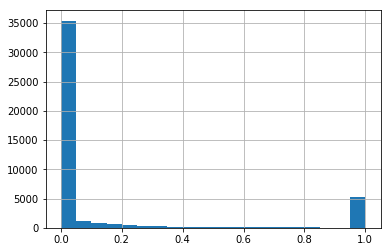

In [71]:
remote = work.groupby(['TUCASEID','TUDIARYDATE','Remote'])['TUACTDUR24'].sum().unstack(level=-1).reset_index()
remote[[0,1]]=remote[[0,1]].fillna(0)
remote['%rmt'] = remote[1]/(remote[0]+remote[1])
remote['%rmt'].hist(bins=20) # Define remote worker as remote >= 95%

In [72]:
remote['remote'] = (remote['%rmt']>=0.95).astype(int)
remote['remote'].value_counts()

0    40446
1     5242
Name: remote, dtype: int64

In [81]:
remote[:2]

Remote        TUCASEID TUDIARYDATE      0      1  %rmt  remote
0       20030100014165  2003-01-09  435.0   65.0  0.13       0
1       20030100014209  2003-01-06    0.0  514.0  1.00       1

In [86]:
work_rmt = pd.merge(remote[['TUCASEID','remote']], work, how='left')
print(work_rmt.shape)
work_rmt.drop('Remote',axis=1,inplace=True)
work_rmt[:3]

(115545, 11)


TUCASEID  remote TUDIARYDATE  TUDIARYDAY  TRHOLIDAY  TUACTIVITY_N  \
0  20030100014165       0  2003-01-09           5          0             4   
1  20030100014165       0  2003-01-09           5          0            23   
2  20030100014165       0  2003-01-09           5          0            25   

   TUACTDUR24 TUSTARTTIM TRTIER2P  TEWHERE  
0         435   05:45:00     0501        2  
1          60   21:15:00     0501        1  
2           5   22:30:00     0501        1

#### 1. When, where, and how long do they work?

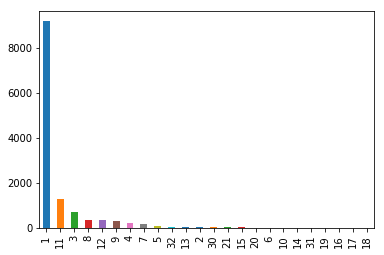

In [89]:
work_rmt[work_rmt['remote']==1]['TEWHERE'].value_counts().plot(kind='bar')

In [107]:
rmt_summ = work_rmt.groupby('TUCASEID')\
    .agg({'remote': lambda x: x.iloc[0],
          'TUDIARYDATE': lambda x: x.iloc[0].year,
          'TUACTIVITY_N':lambda x: len(x),
          'TEWHERE': lambda x: x.nunique(),
          'TUACTDUR24':np.sum})\
    .rename(columns={'remote':'Remote','TUDIARYDATE':'Year','TUACTIVITY_N':'Entries','TEWHERE':'Places','TUACTDUR24':'Minutes'})\
    .reset_index()
#     .unstack(level=0)

In [111]:
rmt_summ.groupby('Remote').mean()

TUCASEID   Entries     Minutes         Year    Places
Remote                                                           
0       2.008908e+13  2.534960  496.266874  2008.844410  1.184592
1       2.009458e+13  2.483022  346.828119  2009.394124  1.199542